In [ ]:
# prompt: importer drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install datasets evaluate loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machin

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification
import torch
from datasets import Dataset
import evaluate
from pathlib import Path
import os
import logging
import csv
from loguru import logger
from os import environ
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# ============================================
# CONFIGURATION INITIALE
# ============================================

# Configuration des chemins
ROOT_DIR = '/content/drive/MyDrive'
DATA_DIR = Path(ROOT_DIR, "projet_ner/data")
CONFIG_DIR = Path(ROOT_DIR, "projet_ner/config")
OUTPUT_DIR = Path(ROOT_DIR, "projet_ner/ner_output")

# Créer les répertoires s'ils n'existent pas
CONFIG_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(OUTPUT_DIR, "ner_training.log")),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

print("Début du processus d'entraînement NER............")

Début du processus d'entraînement NER............


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/projet_ner/data/dataset.csv' , encoding= 'latin-1')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
# ============================================
# ÉTAPE 1: CHARGEMENT DES DONNÉES
# ============================================

csv_file_path = os.path.join(DATA_DIR, "dataset.csv")
print(f"Chargement des données depuis {csv_file_path}")

# Chargement des données
data = []
current_sentence_id = None
current_tokens = []
current_tags = []

try:
    # Open the file with 'latin-1' encoding
    with open(csv_file_path, 'r', encoding='latin-1') as f: # Changed encoding to 'latin-1'
        csv_reader = csv.reader(f)
        header = next(csv_reader, None)  # Ignorer l'en-tête

        for row in csv_reader:
            if not row or len(row) < 4:
                continue

            # Extraire le numéro de phrase
            sentence_part = row[0].strip()

            if "Sentence:" in sentence_part:
                # Nouvelle phrase détectée
                sentence_id_str = sentence_part.replace("Sentence:", "").strip()

                try:
                    sentence_id = int(sentence_id_str)

                    # Sauvegarder la phrase précédente
                    if current_sentence_id is not None and current_tokens:
                        data.append({
                            'sentence_id': current_sentence_id,
                            'tokens': current_tokens,
                            'ner_tags': current_tags
                        })

                    # Réinitialiser pour la nouvelle phrase
                    current_sentence_id = sentence_id
                    current_tokens = []
                    current_tags = []
                except ValueError:
                    logger.warning(f"Could not parse sentence ID: {sentence_id_str}")
                    continue

            # Extraire le token et le tag
            if len(row) >= 4:
                word = row[1].strip()
                tag = row[3].strip()

                if word:  # Ignorer les mots vides
                    current_tokens.append(word)
                    current_tags.append(tag)

    # Ajouter la dernière phrase
    if current_sentence_id is not None and current_tokens:
        data.append({
            'sentence_id': current_sentence_id,
            'tokens': current_tokens,
            'ner_tags': current_tags
        })

    logger.info(f"Données chargées: {len(data)} phrases")
except Exception as e:
    logger.error(f"Erreur lors du chargement des données: {e}")
    raise

Chargement des données depuis /content/drive/MyDrive/projet_ner/data/dataset.csv


In [ ]:
# ============================================
# ÉTAPE 2: INSPECTION ET NETTOYAGE DES DONNÉES
# ============================================

# Inspection des données
print("\nInspection des données (5 premiers échantillons):")
for i, sample in enumerate(data[:5]):
    print(f"\nÉchantillon {i+1}:")
    print(f"Phrase ID: {sample['sentence_id']}")
    print(f"Nombre de tokens: {len(sample['tokens'])}")
    print(f"Nombre de tags: {len(sample['ner_tags'])}")

    print("Quelques tokens et leurs tags:")
    for t, tag in zip(sample['tokens'][:5], sample['ner_tags'][:5]):
        print(f"  '{t}' -> '{tag}'")

    if len(sample['tokens']) != len(sample['ner_tags']):
        print(f"ATTENTION: Incohérence dans les longueurs! tokens={len(sample['tokens'])}, tags={len(sample['ner_tags'])}")
dict_info = {
    'Nombre de phrases': len(data),
    'Nombre de tokens': sum(len(sample['tokens']) for sample in data),
    'Nombre de tags': sum(len(sample['ner_tags']) for sample in data)
}

base = pd.DataFrame([dict_info])
print(base)
# Nettoyage des données
cleaned_data = []
for item in data:
    if len(item['tokens']) != len(item['ner_tags']):
        min_len = min(len(item['tokens']), len(item['ner_tags']))
        item['tokens'] = item['tokens'][:min_len]
        item['ner_tags'] = item['ner_tags'][:min_len]

    if item['tokens']:
        cleaned_data.append(item)
print(f"Après nettoyage: {len(cleaned_data)} phrases valides")

if not cleaned_data:
    print("Aucune donnée valide après nettoyage.")
    raise ValueError("Aucune donnée valide")


Inspection des données (5 premiers échantillons):

Échantillon 1:
Phrase ID: 1
Nombre de tokens: 24
Nombre de tags: 24
Quelques tokens et leurs tags:
  'Thousands' -> 'O'
  'of' -> 'O'
  'demonstrators' -> 'O'
  'have' -> 'O'
  'marched' -> 'O'

Échantillon 2:
Phrase ID: 2
Nombre de tokens: 30
Nombre de tags: 30
Quelques tokens et leurs tags:
  'Families' -> 'O'
  'of' -> 'O'
  'soldiers' -> 'O'
  'killed' -> 'O'
  'in' -> 'O'

Échantillon 3:
Phrase ID: 3
Nombre de tokens: 14
Nombre de tags: 14
Quelques tokens et leurs tags:
  'They' -> 'O'
  'marched' -> 'O'
  'from' -> 'O'
  'the' -> 'O'
  'Houses' -> 'O'

Échantillon 4:
Phrase ID: 4
Nombre de tokens: 15
Nombre de tags: 15
Quelques tokens et leurs tags:
  'Police' -> 'O'
  'put' -> 'O'
  'the' -> 'O'
  'number' -> 'O'
  'of' -> 'O'

Échantillon 5:
Phrase ID: 5
Nombre de tokens: 25
Nombre de tags: 25
Quelques tokens et leurs tags:
  'The' -> 'O'
  'protest' -> 'O'
  'comes' -> 'O'
  'on' -> 'O'
  'the' -> 'O'
   Nombre de phrases  No

In [ ]:
# ============================================
# ÉTAPE 3: EXTRACTION DES ÉTIQUETTES UNIQUES
# ============================================

# Extraire toutes les étiquettes NER uniques
all_tags = set()
for item in cleaned_data:
    all_tags.update(item['ner_tags'])
unique_tags = sorted(list(all_tags))

print(f"Étiquettes NER trouvées: {unique_tags}")

# Créer les mappages
id2label = {i: label for i, label in enumerate(unique_tags)}
label2id = {label: i for i, label in id2label.items()}

Étiquettes NER trouvées: ['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O']


In [ ]:
# ============================================
# ÉTAPE 4: PRÉPARATION DES DATASETS
# ============================================

# Convertir en DataFrame
df = pd.DataFrame(cleaned_data)

# Créer le Dataset
dataset = Dataset.from_pandas(df)

# Diviser en train/test
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

print(f"Taille du jeu d'entraînement: {len(train_dataset)}")
print(f"Taille du jeu d'évaluation: {len(eval_dataset)}")

Taille du jeu d'entraînement: 38367
Taille du jeu d'évaluation: 9592


In [ ]:
# ============================================
# ÉTAPE 5: TOKENIZATION ET ALIGNEMENT DES LABELS
# ============================================

# Initialiser le tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Fonction de tokenization (gardée comme fonction car utilisée avec .map())
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                try:
                    label_ids.append(label2id[label[word_idx]])
                except (IndexError, KeyError):
                    label_ids.append(-100)
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs
# Appliquer la tokenization
train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
eval_dataset = eval_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/38367 [00:00<?, ? examples/s]

Map:   0%|          | 0/9592 [00:00<?, ? examples/s]

TypeError: tokenize_and_align_labels() missing 1 required positional argument: 'examples'

In [ ]:
tokenize_and_align_labels(examples)

NameError: name 'examples' is not defined

In [ ]:
# ============================================
# ÉTAPE 6: INITIALISATION DU MODÈLE
# ============================================

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(unique_tags),
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# 3. Définir la fonction compute_metrics
data_collator = DataCollatorForTokenClassification(tokenizer)
def compute_metrics(p):
    metric = evaluate.load("seqeval")
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for prediction, label in zip(predictions, labels):
        true_pred = []
        true_lab = []

        for p, l in zip(prediction, label):
            if l != -100:
                try:
                    true_pred.append(id2label[p])
                    true_lab.append(id2label[l])
                except KeyError:
                    true_pred.append("O")
                    true_lab.append("O")

        true_predictions.append(true_pred)
        true_labels.append(true_lab)

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# 4. Enfin créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,  # Maintenant la variable est définie
    compute_metrics=compute_metrics,
)

logger.info("Configuration de l'entraînement terminée")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-17-d03cf56cde7a>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=342a2db1b9c4c72aab99d6daf929fa37fe8b494bad90cdff9b99893e56e72299
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
import seqeval

In [ ]:
# ============================================
# ÉTAPE 8: ENTRAÎNEMENT DU MODÈLE
# ============================================

logger.info("Début de l'entraînement...")
trainer.train()

# ============================================
# ÉTAPE 9: SAUVEGARDE DU MODÈLE
# ============================================

model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
logger.info(f"Modèle sauvegardé dans {OUTPUT_DIR}")

logger.info("Processus terminé avec succès!")

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.079300,0.085643,0.828639,0.849629,0.839003,0.972370
2,0.064100,0.084329,0.838883,0.855423,0.847072,0.973685
3,0.047400,0.089688,0.847066,0.856995,0.852002,0.974337


Epoch,Training Loss,Validation Loss


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
# Load the saved model and tokenizer
model_path = "/content/drive/MyDrive/projet_ner/ner_output"  # Replace with your actual model path

# Load the actual model and tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

def predict_entities(text, model, tokenizer, id2label):
    results = ner_pipeline(text)
    tokens = []
    labels = []
    for entity in results:
        tokens.append(entity['word'])
        # Access the entity group using the 'entity' key instead of 'entity_group'
        labels.append(entity['entity'])
    return tokens, labels

# Example usage:
test_sentence = "John is planning a trip to Paris next summer. He will visit the Eiffel Tower on July 15th and then travel to London on July 20th i work Air France flight"
tokens, labels = predict_entities(test_sentence, model, tokenizer, id2label)

print("\nRésultats de la prédiction:")
for token, label in zip(tokens, labels):
    print(f"{token}: {label}")

Device set to use cpu



Résultats de la prédiction:
John: B-per
Paris: B-geo
summer: B-tim
Eiffel: B-org
Tower: I-org
July: B-tim
15th: I-tim
London: B-geo
July: B-tim
20th: I-tim
Air: B-geo
France: I-geo


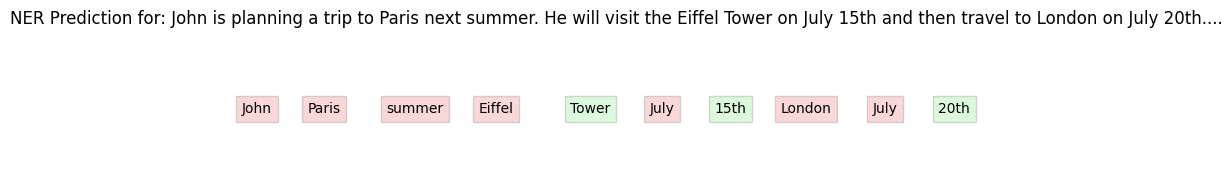

In [ ]:
# prompt: je veux une meilleur visualisation de la prédiction

import matplotlib.pyplot as plt

def visualize_prediction(text, tokens, labels):
    """Visualizes the NER prediction using matplotlib."""

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 2))  # Adjust figure size as needed

    # Calculate the positions of the tokens
    token_positions = []
    current_position = 0
    for token in tokens:
      token_positions.append(current_position)
      current_position += len(token) + 1 # Adding 1 for the space between tokens


    # Plot the tokens
    for i, (token, label) in enumerate(zip(tokens, labels)):
        color = 'skyblue' # Default color
        if label != 'O':
            if label.startswith('B'):
              color = 'lightcoral'
            elif label.startswith('I'):
              color = 'lightgreen'  # Different color for inside entities
        ax.text(token_positions[i], 0.5, token, ha='left', va='center', color='black', bbox=dict(facecolor=color, alpha=0.3, edgecolor='grey'))

    # Set the axis limits and labels
    ax.set_xlim(-1, current_position)
    ax.set_ylim(0, 1)
    ax.axis('off')

    # Add title and labels
    plt.title(f"NER Prediction for: {text}")

    # Display the plot
    plt.show()


# Example usage (assuming you have 'test_sentence', 'tokens', and 'labels' defined)
test_sentence = "John is planning a trip to Paris next summer. He will visit the Eiffel Tower on July 15th and then travel to London on July 20th...."
tokens, labels = predict_entities(test_sentence, model, tokenizer, id2label)
visualize_prediction(test_sentence, tokens, labels)
